# WZE-UAV Image Classification using Deep Learning

In [1]:
import os
import gc
import glob
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

In [2]:
import torch
import torchvision.transforms as T
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from mlxtend.plotting import plot_confusion_matrix

In [3]:
import wze_uav.data_loader as data_loader
import wze_uav.models as models
from wze_uav.engine import *
from wze_uav.utils2 import *
#from wze_uav.log_writer import create_writer
from wze_uav.datasplit import *
from efficientnet import model_effnet #for custom effnet with n_channels input
import wandb

#### Get PyTorch version

In [4]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


#### Preparing device agnostic code 

In [5]:
# ensure device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# get index of currently selected device
print(f"Index of current divice: {torch.cuda.current_device()}")
# get number of GPUs available
print(f"Number of GPUs available: {torch.cuda.device_count()}")
# get the name of the device
print(f"GPU Model: {torch.cuda.get_device_name(0)}")

cuda
Index of current divice: 0
Number of GPUs available: 1
GPU Model: Quadro RTX 8000


#### Login to Weights & Biases to track results

In [6]:
# IMPORTANT: The proxy needs to be set in anaconda!
# copy paste this in anaconda and restart jupyter notebook
#set http_proxy=http://www-proxy.bayern.de:80
#set https_proxy=http://www-proxy.bayern.de:80
wandb.login()
#wandb.init(settings=wandb.Settings(start_method="thread"))
wandb.init(project='wze-uav-combined-11classes', entity='simon-ecke')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: simon-ecke. Use `wandb login --relogin` to force relogin


#### Ensure reproducibility 

In [6]:
# for more information, see also: https://pytorch.org/docs/stable/notes/randomness.html

# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)
    # seed for numpy
    np.random.seed(seed)

set_seeds(42) 

# Set to true -> might speed up the process but should be set to False if reproducible results are desired
torch.backends.cudnn.benchmark = False


#### Define file directory

In [7]:
#####################################################################################
# 3 channel input (r-g-b)
#data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\Datasplit\ROI\rgb"

# 4 channel input (r-g-b-nir)
#data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\Datasplit\ROI\rgb-nir"

# 5 channel input (r-g-b-re-nir)
data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\Datasplit\ROI\rgb-re-nir"

# 6 channel input (r-g-b-re-nir)
#data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\Datasplit\ROI\rgb-re-nir-chm"

#####################################################################################

#### Get all file paths, years and plotIDs

In [8]:
fn_list = os.listdir(data_path)
path_list = []
#year_list = []
#plotID_list = []
# Iterate over all datafiles
for year in fn_list:
    year_dir = f'{data_path}\\{year}'
    for filename in os.listdir(year_dir):
        path = f'{year_dir}\\{filename}'
        #plotID = path.rsplit('_',1)[0].rsplit('r',1)[1]
        path_list.append(path)
        #year_list.append(year)
        #plotID_list.append(plotID)

#### Get unique plotIDs and years per available trees

In [9]:
plotID_dict = data_loader.get_plotID(path_list)

Creating unique tree IDs...:   0%|          | 0/647 [00:00<?, ?it/s]

#### Import all imagery, labels and other features from hdf5 files

In [10]:
image_set, label_set, species_set, kkl_set, bk_set, hash_id = data_loader.hdf5_to_img_label(path_list,
                                                                                               plotID_dict,
                                                                                               load_sets=["images_masked"])

Processing hdf5 datasets:   0%|          | 0/647 [00:00<?, ?it/s]

In [12]:
def combined_to_classesv3(species_set: np.array, nbv_set: np.array, image_set: np.array, kkl_set: np.array, bk_set: np.array, hash_id: np.array):
    
    species_list = []
    oak_species = [48, 51]
    acer_species = [5, 4, 1]
    larix_species = [116, 117]
    #other_conifers = [103, 104, 106, 116, 117, 119, 120, 123, 128, 129, 133, 135, 136, 137]
    for i in range(len(species_set)):
        if nbv_set[i] >= 99: # dead trees
            tree = 13
            species_list.append(tree)
        elif species_set[i] == 118 and nbv_set[i] >= 0 and nbv_set[i] <= 25: # healthy spruces
            tree = 0
            species_list.append(tree)
        elif species_set[i] == 118 and nbv_set[i] >= 30 and nbv_set[i] <= 95: # stressed spruces
            tree = 1
            species_list.append(tree)
        elif species_set[i] == 134 and nbv_set[i] >= 0 and nbv_set[i] <= 25: # healthy pines
            tree = 2
            species_list.append(tree)
        elif species_set[i] == 134 and nbv_set[i] >= 30 and nbv_set[i] <= 95: # stressed pines
            tree = 3
            species_list.append(tree)
        elif species_set[i] == 100 and nbv_set[i] >= 0 and nbv_set[i] <= 25: # healthy firs
            tree = 4
            species_list.append(tree)
        elif species_set[i] == 100 and nbv_set[i] >= 30 and nbv_set[i] <= 95: # stressed firs
            tree = 5
            species_list.append(tree)
        elif species_set[i] == 20 and nbv_set[i] >= 0 and nbv_set[i] <= 25: # healthy beeches
            tree = 6
            species_list.append(tree)
        elif species_set[i] == 20 and nbv_set[i] >= 30 and nbv_set[i] <= 95: # stressed beeches
            tree = 7
            species_list.append(tree)
        elif species_set[i] in oak_species and nbv_set[i] >= 0 and nbv_set[i] <= 25: # healthy oaks
            tree = 8
            species_list.append(tree)
        elif species_set[i] in oak_species and nbv_set[i] >= 30 and nbv_set[i] <= 95: # stressed oaks
            tree = 9
            species_list.append(tree)
        elif species_set[i] in larix_species and nbv_set[i] >=0: # Larix decidua/kaempferi
            tree = 10
            species_list.append(tree)
        elif species_set[i] in acer_species and nbv_set[i] >=0: # acer spp.
            tree = 11
            species_list.append(tree)
        elif species_set[i] == 10 and nbv_set[i] >= 0: # Betula pendula
            tree = 12
            species_list.append(tree)
        else:
            tree = 999
            species_list.append(tree) # other broad-leaved trees
            
    species_setv2 = np.array(species_list)
    label_set = species_setv2
    
    np_filter = []
    for i in range(0, len(bk_set)):
        if label_set[i] in [0,1,2,3,4,5,6,7,8,9,10,11,12,13]:
            np_filter.append(True)
        else:
            np_filter.append(False)
         
    image_set = image_set[np_filter]
    label_set = label_set[np_filter]
    species_set = species_set[np_filter]
    kkl_set = kkl_set[np_filter]
    bk_set = bk_set[np_filter]
    hash_id = hash_id[np_filter]
    
    return image_set, label_set, species_set, kkl_set, bk_set, hash_id

#### Convert nbv to classes

In [11]:
nbv_set = label_set
image_set, label_set, species_set, kkl_set, bk_set, hash_id = combined_to_classesv2(species_set, nbv_set, image_set, kkl_set, bk_set, hash_id)

#### Split data into subset (used for training and validation in the 5-fold cross-validation) and test set

In [12]:
sub_image_set, sub_label_set, sub_hash_id, sub_species_set, test_image_set, test_label_set, test_hash_id, test_species_set = data_split(image_set, label_set, hash_id, species_set, n_splits=6, random_state=42, seed=2)


ORIGINAL POSITIVE RATIO: 3.5131213512441195
Fold : 0
TRAIN POSITIVE RATIO: 3.4969274887341255
TEST POSITIVE RATIO : 3.592258925592259
LENGTH TRAIN GROUPS : 195
LENGTH TEST GROUPS  : 40
Number of True in sub_indices: 14646
Number of False in sub_indices: 2997
Number of True in test_indices: 1102
Number of False in test_indices: 16541
Check shapes:

Images sub dataset: (14646, 250, 250, 5)
Labels sub dataset: (14646, 1)

Images test dataset: (1102, 250, 250, 5)
Labels test dataset: (1102, 1)

--------------------------------------------------
Check if the split was stratified: (random_state=42)
Healthy trees in sub dataset: 3561
Stressed trees in sub dataset: 2068
Dead trees in sub dataset: 1834
Healthy trees in test dataset: 338
Stressed trees in test dataset: 147
Dead trees in test dataset: 107
Ratio health trees in test dataset: 0.09491715810165684
Ratio stressed trees in test dataset: 0.07108317214700194
Ratio dead trees in test dataset: 0.05834242093784078


#### Check if any hash ID is in both sub and test dataset

In [16]:
hash_set = set(sub_hash_id[:,0].flatten())
test_hash_set = set(test_hash_id[:,0].flatten())
intersection = hash_set.intersection(test_hash_set)
if intersection:
    print(f"Hash_id values in both train and test sets: {len(intersection)}")
else:
    print("There are no hash_id values in both train and test datasets. The datasplit was successful")

There are no hash_id values in both train and test datasets. The datasplit was successful


#### Check feature distribution of the Test dataset

In [17]:
def count_occurrences(data, value):
    count = 0
    for item in data:
        if item == value:
            count += 1
    return count

print("Test dataset")
print(f"Test data Picea abies healthy: {count_occurrences(test_label_set, 0)}")
print(f"Test data Picea abies stressed: {count_occurrences(test_label_set, 1)}")
print(f"Test data Pinus sylvestris healthy: {count_occurrences(test_label_set, 2)}")
print(f"Test data Pinus sylvestris stressed: {count_occurrences(test_label_set, 3)}")
print(f"Test data Abies alba healthy: {count_occurrences(test_label_set, 4)}")
print(f"Test data Abies alba stressed: {count_occurrences(test_label_set, 5)}")
print(f"Test data Fagus sylvatica healthy: {count_occurrences(test_label_set, 6)}")
print(f"Test data Fagus sylvatica stressed: {count_occurrences(test_label_set, 7)}")
print(f"Test data Quercus robur/petraea healthy: {count_occurrences(test_label_set, 8)}")
print(f"Test data Quercus robur/petraea stressed: {count_occurrences(test_label_set, 9)}")
print(f"Test data Larix spp.: {count_occurrences(test_label_set, 10)}")
print(f"Test data Acer spp.: {count_occurrences(test_label_set, 11)}")
print(f"Test data Betula pendula: {count_occurrences(test_label_set, 12)}")
print(f"Test data dead trees: {count_occurrences(test_label_set, 13)}")
print("-"*50)

print("Remaining dataset")
print(f"Remaining data Picea abies healthy: {count_occurrences(sub_label_set, 0)}")
print(f"Remaining data Picea abies stressed: {count_occurrences(sub_label_set, 1)}")
print(f"Remaining data Pinus sylvestris healthy: {count_occurrences(sub_label_set, 2)}")
print(f"Remaining data Pinus sylvestris stressed: {count_occurrences(sub_label_set, 3)}")
print(f"Remaining data Abies alba healthy: {count_occurrences(sub_label_set, 4)}")
print(f"Remaining data Abies alba stressed: {count_occurrences(sub_label_set, 5)}")
print(f"Remaining data Fagus sylvatica healthy: {count_occurrences(sub_label_set, 6)}")
print(f"Remaining data Fagus sylvatica stressed: {count_occurrences(sub_label_set, 7)}")
print(f"Remaining data Quercus robur/petraea healthy: {count_occurrences(sub_label_set, 8)}")
print(f"Remaining data Quercus robur/petraea stressed: {count_occurrences(sub_label_set, 9)}")
print(f"Test data Larix spp.: {count_occurrences(sub_label_set, 10)}")
print(f"Test data Acer spp.: {count_occurrences(sub_label_set, 11)}")
print(f"Test data Betula pendula: {count_occurrences(sub_label_set, 12)}")
print(f"Remaining data dead trees: {count_occurrences(sub_label_set, 13)}")
print("-"*50)

Test dataset
Test data Picea abies healthy: 338
Test data Picea abies stressed: 147
Test data Pinus sylvestris healthy: 107
Test data Pinus sylvestris stressed: 166
Test data Abies alba healthy: 19
Test data Abies alba stressed: 15
Test data Fagus sylvatica healthy: 76
Test data Fagus sylvatica stressed: 44
Test data Quercus robur/petraea healthy: 61
Test data Quercus robur/petraea stressed: 20
Test data Larix spp.: 45
Test data Acer spp.: 20
Test data Betula pendula: 13
Test data dead trees: 31
--------------------------------------------------
Remaining dataset
Remaining data Picea abies healthy: 3561
Remaining data Picea abies stressed: 2068
Remaining data Pinus sylvestris healthy: 1834
Remaining data Pinus sylvestris stressed: 2073
Remaining data Abies alba healthy: 437
Remaining data Abies alba stressed: 140
Remaining data Fagus sylvatica healthy: 1287
Remaining data Fagus sylvatica stressed: 953
Remaining data Quercus robur/petraea healthy: 735
Remaining data Quercus robur/petrae

In [13]:
# train transform with augmentation. 
transform_train = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomRotation(degrees=[0,360])])

# test and val dataset transform without augmentation. 
transform = transforms.Compose([transforms.ToTensor()])

# class names need to fit the customDataset class used e.g. 3 classes -> use CustomDataset3Classes
#class_names = ['healthy', 'slightly_stressed', 'moderately_stressed', 'highly_stressed', 'dead']
#class_names = ['healthy', 'moderately_stressed', 'highly_stressed', 'dead']
#class_names = ['healthy', 'moderate stress', 'severe stress', 'dead']
class_names = ['Picea abies healthy', 'Picea abies stressed', 'Pinus sylvestris healthy', 'Pinus sylvestris stressed', 
               'Abies alba healthy', 'Abies alba stressed', 'Fagus sylvatica healthy', 'Fagus sylvatica stressed',
               'Quercus ssp. healthy', 'Quercus ssp. stressed', 'dead trees']

# set seeds
g = torch.Generator()
g.manual_seed(42)
NUM_WORKERS=3 # should be changed, depending on the system used
batch_size=32

#### Define variables and parameters

In [14]:
# 1. Define number of epochs
epochs = 50
n_bands = sub_image_set[0].shape[2] # get number of bands

# 2. Define model
num_classes = len(class_names)
unfreeze = True # all layer weights get updated
dropout_rate = 0.5 #define dropout rate
model_name = "EffNet_b7_RGB-RE-NIR-11classes-combined_plotsplit"

# 3. Define loss, optimizer and learning rate scheduler
lr = 0.001 # define learning rate
min_lr = 1e-6 # minimum learning rate threshold
gamma = 0.75 # how fast the learning rate decreases per epoch (low number=faster decrease)
patience = 10

# 4. Create target folder name were to save the tensorboard event files
experiment_name = 'RGB-RE-NIR-11classes-combined_plotsplit'
extra = "RGB-RE-NIR-11classes-combined_plotsplit"

#----------------------------------------------------------------------
#torch.cuda.empty_cache()
print(f"Memory allocated: {torch.cuda.memory_allocated()} bytes") 

Memory allocated: 0 bytes


In [20]:
class_names

['Picea abies healthy',
 'Picea abies stressed',
 'Pinus sylvestris healthy',
 'Pinus sylvestris stressed',
 'Abies alba healthy',
 'Abies alba stressed',
 'Fagus sylvatica healthy',
 'Fagus sylvatica stressed',
 'Quercus ssp. healthy',
 'Quercus ssp. stressed',
 'dead trees']

In [21]:
import torch
from torch.utils.data import Dataset

class FilteredDataset(Dataset):
    def __init__(self, dataset, class_indices):
        self.dataset = dataset
        self.class_indices = class_indices
        self.filtered_indices = self._filter_indices()

    def _filter_indices(self):
        # Filter the indices based on class_indices
        filtered_indices = [i for i in range(len(self.dataset)) if self.dataset[i][1] in self.class_indices]
        return filtered_indices

    def __getitem__(self, index):
        filtered_index = self.filtered_indices[index]
        image, label = self.dataset[filtered_index]

        # Return the image and filtered label
        return image, label

    def __len__(self):
        # Compute the length of the filtered dataset
        return len(self.filtered_indices)

    @property
    def labels(self):
        # Return the filtered labels with renamed index 13 to 10
        filtered_labels = [self.dataset[i][1] for i in self.filtered_indices]
        renamed_labels = [label if label < 13 else 10 for label in filtered_labels]
        return renamed_labels




In [22]:
label_list

NameError: name 'label_list' is not defined

In [23]:

import torch
import os
import findatree_roi.io as io
import findatree_roi.exporter as exporter
import numpy as np
from torch.utils.data import Dataset
from typing import Dict, List, Tuple
from torch.utils.data import WeightedRandomSampler
from tqdm.auto import tqdm
from collections import defaultdict
import hashlib


def data_samplerv2(dataset: Dataset, class_names: List[str]):
    
    label_list = dataset.labels
    #label_list = []
    #for label in labels_list:
    #    label = label[0]
    #    label_list.append(label)
    
    # count the number of samples per class
    class_sample_counts = [label_list.count(i) for i in range(len(class_names))]
    
    # compute the effective number of samples
    total_samples = sum(class_sample_counts)
    effective_num = [(1.0 - (count / total_samples)) / (len(class_names) - 1) for count in class_sample_counts]
    
    # calculate the weight of each class as inverse of frequency
    class_weights = torch.FloatTensor(effective_num)
    class_weights /= torch.sum(class_weights)
    
    # create a list of weights for each data sample
    train_weights = [class_weights[label] for label in label_list]
    
    # create a sampler using the weights
    sampler = WeightedRandomSampler(train_weights, len(dataset), replacement=True)
 
    return sampler

#### Run k-Fold cross-validation on EfficientNet

In [ ]:
%%time

# Set the random seeds
set_seeds(42)

# Define the number of folds
num_folds = 5

# group the hashIDs to get the unique values of hashIDs remaining in the subset  
groups = sub_hash_id[:, 0] 
print("ORIGINAL POSITIVE RATIO:", sub_label_set.mean())
# create a StratifiedGroupKFold instance
kf = StratifiedGroupKFold(n_splits=num_folds, shuffle=True, random_state=42)

# loop through the folds
for fold, (train_ids, val_ids) in enumerate(kf.split(sub_image_set, sub_label_set, groups)):
    print("Fold :", fold+1)
    print("TRAIN POSITIVE RATIO:", sub_label_set[train_ids].mean())
    print("VAL POSITIVE RATIO  :", sub_label_set[val_ids].mean())
    print("LENGTH TRAIN GROUPS :", len(set(groups[train_ids])))
    print("LENGTH VAL GROUPS   :", len(set(groups[val_ids])))
    
    train_ids = sub_hash_id[:, 0][train_ids]
    val_ids = np.unique(sub_hash_id[:, 0][val_ids])

    torch.cuda.empty_cache()
    
    # Initialize a new wandb run for this fold
    wandb.init(project='wze-uav-combined-11classes', name=f"fold_{fold + 1}_{extra}")
    
    # 1. Split data into train and validation set
    # Get the training and testing data for this fold
    # Use np.isin() to create boolean arrays indicating which indices belong to train or test sets
    train_indices = np.isin(sub_hash_id[:,0], train_ids)
    
    val_indices = np.zeros_like(train_indices)  # initialize to all False
    for hash_id_val in val_ids:
        # select one image ID randomly from either 2020 or 2021 or 2022 for each unique hash ID in the test set
        temp = np.unique(sub_hash_id[(sub_hash_id[:, 0] == hash_id_val), 1]) # check how many years are available per hashID
        if len(temp) == 1:
            year = temp[0]
        elif len(temp) == 2:
            year = np.random.choice(temp)
        else:
            year = np.random.choice(temp)
        
        # select image ID using the conditions
        image_ids = sub_hash_id[(sub_hash_id[:,0] == hash_id_val) & (sub_hash_id[:,1] == year), 0]
    
        # mark the index corresponding to the selected image ID and hash ID as True in the test indices array
        val_indices[(sub_hash_id[:,0] == hash_id_val) & (sub_hash_id[:,1] == year) & (np.isin(sub_hash_id[:,0], image_ids))] = True 
    
    # Reshape boolean arrays to match shape of image_set and label_set
    train_indices = train_indices.reshape(-1, 1)
    val_indices = val_indices.reshape(-1, 1)
    
    # Select images and labels for train and validation sets
    train_image_set = sub_image_set[train_indices[:, 0]]
    train_label_set = sub_label_set[train_indices[:, 0]]
    train_hash_id = sub_hash_id[train_indices[:, 0]][:,0]
    train_species_set = sub_species_set[train_indices[:, 0]]
    val_image_set = sub_image_set[val_indices[:, 0]]
    val_label_set = sub_label_set[val_indices[:, 0]]
    val_hash_id = sub_hash_id[val_indices[:, 0]][:,0]
    val_species_set = sub_species_set[val_indices[:, 0]]
    # reshape 
    train_label_set = train_label_set.reshape(-1, 1)
    val_label_set = val_label_set.reshape(-1, 1)
    train_species_set = train_species_set.reshape(-1, 1)
    val_species_set = val_species_set.reshape(-1, 1)
    
    # check if there are any group overlaps between the data splits
    hash_set = set(train_hash_id)
    val_hash_set = set(val_hash_id)
    test_hash_set = set(test_hash_id[:, 0].flatten())
    intersection = hash_set.intersection(val_hash_set)
    intersection2 = test_hash_set.intersection(val_hash_set)
    intersection3 = hash_set.intersection(test_hash_set)
    if intersection:
        print(f"Hash_id values in both train and val sets: {len(intersection)}")
        print(f"Hash_id values in both test and val sets: {len(intersection2)}")
        print(f"Hash_id values in both train and test sets: {len(intersection3)}")
    else:
        print("There are no same hash_id values in train, val or test datasets. The datasplit was successful")
    
         
    print("Check shapes:\n")
    print(f"Images train dataset: {train_image_set.shape}")
    print(f"Labels train dataset: {train_label_set.shape}\n")
    
    print(f"Images validation dataset: {val_image_set.shape}")
    print(f"Labels validation dataset: {val_label_set.shape}\n")
    print('-'*50)
    print (f"Check if the split was stratified: (random_state=42)")
    print(f"Picea abies healthy in train dataset: {np.count_nonzero(train_label_set == 0)}")
    print(f"Picea abies stressed in train dataset: {np.count_nonzero(train_label_set == 1)}")
    print(f"Pinus sylvestris healthy in train dataset: {np.count_nonzero(train_label_set == 2)}")
    print(f"Pinus sylvestris stressed in train dataset: {np.count_nonzero(train_label_set == 3)}")
    print(f"Abies alba healthy in train dataset: {np.count_nonzero(train_label_set == 4)}")
    print(f"Abies alba stressed in train dataset: {np.count_nonzero(train_label_set == 5)}")
    print(f"Fagus sylvatica healthy in train dataset: {np.count_nonzero(train_label_set == 6)}")
    print(f"Fagus sylvatica stressed in train dataset: {np.count_nonzero(train_label_set == 7)}")
    print(f"Quercus robur/petraea healthy in train dataset: {np.count_nonzero(train_label_set == 8)}")
    print(f"Quercus robur/petraea stressed in train dataset: {np.count_nonzero(train_label_set == 9)}")
    print(f"Dead trees in train dataset: {np.count_nonzero(train_label_set == 10)}")
    print(f"Picea abies healthy in validation dataset: {np.count_nonzero(val_label_set == 0)}")
    print(f"Picea abies stressed in validation dataset: {np.count_nonzero(val_label_set == 1)}")
    print(f"Pinus sylvestris healthy in validation dataset: {np.count_nonzero(val_label_set == 2)}")
    print(f"Pinus sylvestris stressed in validation dataset: {np.count_nonzero(val_label_set == 3)}")
    print(f"Abies alba healthy in validation dataset: {np.count_nonzero(val_label_set == 4)}")
    print(f"Abies alba stressed in validation dataset: {np.count_nonzero(val_label_set == 5)}")
    print(f"Fagus sylvatica healthy in validation dataset: {np.count_nonzero(val_label_set == 6)}")
    print(f"Fagus sylvatica stressed in validation dataset: {np.count_nonzero(val_label_set == 7)}")
    print(f"Quercus robur/petraea healthy in validation dataset: {np.count_nonzero(val_label_set == 8)}")
    print(f"Quercus robur/petraea stressed in validation dataset: {np.count_nonzero(val_label_set == 9)}")
    print(f"Dead trees in validation dataset: {np.count_nonzero(val_label_set == 10)}")
    #print(f"Ratio health trees in validation dataset: {np.count_nonzero(val_label_set == 0)/np.count_nonzero(sub_label_set == 0)}")
    #print(f"Ratio moderately stressed trees in validation dataset: {np.count_nonzero(val_label_set == 1)/np.count_nonzero(sub_label_set == 1)}")
    #print(f"Ratio severely stressed trees in validation dataset: {np.count_nonzero(val_label_set == 1)/np.count_nonzero(sub_label_set == 2)}")
    #print(f"Ratio dead trees in validation dataset: {np.count_nonzero(val_label_set == 2)/np.count_nonzero(sub_label_set == 3)}")
    print("-"*50)
   
    # 2. Create train and validation dataset. (choose custom dataset loader with 3 - 5 classes)
    print(f"\nCreating datasets for fold: {fold + 1}\n")
    train_dataset = data_loader.CustomDataset(data=train_image_set, labels=train_label_set, class_names=class_names, species = train_species_set,
                                                         transform=transform_train)
    
    val_dataset = data_loader.CustomDataset(data=val_image_set, labels=val_label_set, class_names=class_names,
                                                       species = val_species_set, transform=transform)
    print(len(train_dataset))
    print(len(val_dataset))
    
    ## filter out Larix, Acer, and Betula
    # Define the class indices you want to keep
    class_indices_to_keep = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13]

    # Create the filtered dataset
    train_dataset = FilteredDataset(train_dataset, class_indices_to_keep)
    val_dataset = FilteredDataset(val_dataset, class_indices_to_keep)
    
    print(len(train_dataset))
    print(len(val_dataset))
   
    # 3. Create train and validation dataloader
    # create sampler for oversampling of the minority classes
    sampler = data_samplerv2(dataset=train_dataset, class_names=class_names)
    print(f"Creating dataloaders for fold: {fold +1}\n")
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, persistent_workers=True, pin_memory=True, num_workers=NUM_WORKERS, generator=g,
                              sampler=sampler, shuffle=False, drop_last=True) # shuffle false because of the sampler

    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, persistent_workers=True, pin_memory=True, num_workers=NUM_WORKERS, shuffle=False,
                             drop_last=True)
    
    model = model_effnet.EfficientNet.from_pretrained('efficientnet-b7', in_channels=n_bands, num_classes=num_classes, dropout_rate=dropout_rate)
    #model = models.create_effnetb7(output_shape=num_classes, unfreeze=True, dropout_rate=dropout_rate, device=device)
   
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    lr_scheduler = CustomExponentialLR(optimizer, gamma=gamma, min_lr=min_lr)

    fold += 1
    print(f"\n[INFO] Fold number: {fold}")
    print(f"[INFO] Number of epochs: {epochs}")
    print(f"[INFO] Batch_size: {batch_size}")
    print(f"[INFO] Number of bands: {n_bands}")
    print(f"[INFO] Dropout rate: {dropout_rate}")
    print(f"[INFO] Gamma learning rate: {gamma}")
    print(f"[INFO] Memory allocated: {torch.cuda.memory_allocated()} bytes")
    # 4. Train model with k fold dataloaders and track experiments
    
    if fold == 1:
        fold1_results = train(model=model, model_name=model_name, n_bands=n_bands, batch_size=batch_size,train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                        optimizer=optimizer, loss_fn=loss_fn, lr_scheduler=lr_scheduler, num_classes=num_classes, epochs=epochs, experiment_num=fold, device=device,
                        writer=None, early_stop_patience = patience)
       
    elif fold == 2:
        fold2_results = train(model=model, model_name=model_name, n_bands=n_bands, batch_size=batch_size,train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                        optimizer=optimizer, loss_fn=loss_fn, lr_scheduler=lr_scheduler, num_classes=num_classes, epochs=epochs, experiment_num=fold, device=device,
                        writer=None, early_stop_patience = patience)
    elif fold == 3:
        fold3_results = train(model=model, model_name=model_name, n_bands=n_bands, batch_size=batch_size,train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                        optimizer=optimizer, loss_fn=loss_fn, lr_scheduler=lr_scheduler, num_classes=num_classes, epochs=epochs, experiment_num=fold, device=device,
                        writer=None, early_stop_patience = patience)
    elif fold == 4:
        fold4_results = train(model=model, model_name=model_name, n_bands=n_bands, batch_size=batch_size,train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                        optimizer=optimizer, loss_fn=loss_fn, lr_scheduler=lr_scheduler, num_classes=num_classes, epochs=epochs, experiment_num=fold, device=device,
                        writer=None, early_stop_patience = patience)
    else:
        fold5_results = train(model=model, model_name=model_name, n_bands=n_bands, batch_size=batch_size,train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                        optimizer=optimizer, loss_fn=loss_fn, lr_scheduler=lr_scheduler, num_classes=num_classes, epochs=epochs, experiment_num=fold, device=device,
                        writer=None, early_stop_patience = patience)
    
    del train_indices, val_indices, train_image_set, train_label_set, train_hash_id, train_species_set, val_image_set, val_label_set, val_hash_id, val_species_set,
    train_dataset, val_dataset, sampler, train_dataloader, val_dataloader, model, loss_fn, optimizer, lr_scheduler
    
    #finish the wandb run
    wandb.finish()
    print("Deleting variables and emptying cache")
    gc.collect()
    torch.cuda.empty_cache()
    print(f"Memory allocated: {torch.cuda.memory_allocated()} bytes")
    print("-"*50 + "\n")

ORIGINAL POSITIVE RATIO: 3.4969274887341255
Fold : 1
TRAIN POSITIVE RATIO: 3.3526866833953446
VAL POSITIVE RATIO  : 4.036581417934607
LENGTH TRAIN GROUPS : 156
LENGTH VAL GROUPS   : 39


There are no same hash_id values in train, val or test datasets. The datasplit was successful
Check shapes:

Images train dataset: (11557, 250, 250, 5)
Labels train dataset: (11557, 1)

Images validation dataset: (1104, 250, 250, 5)
Labels validation dataset: (1104, 1)

--------------------------------------------------
Check if the split was stratified: (random_state=42)
Picea abies healthy in train dataset: 2879
Picea abies stressed in train dataset: 1542
Pinus sylvestris healthy in train dataset: 1540
Pinus sylvestris stressed in train dataset: 1835
Abies alba healthy in train dataset: 392
Abies alba stressed in train dataset: 125
Fagus sylvatica healthy in train dataset: 974
Fagus sylvatica stressed in train dataset: 631
Quercus robur/petraea healthy in train dataset: 532
Quercus robur/petraea stressed in train dataset: 273
Dead trees in train dataset: 265
Picea abies healthy in validation dataset: 255
Picea abies stressed in validation dataset: 174
Pinus sylvestris healthy in vali

  0%|          | 0/50 [00:00<?, ?it/s]

#### Create test dataset and test dataloader 

In [15]:
test_dataset = data_loader.FilteredTestDataset(
    data = test_image_set,
    labels = test_label_set,
    class_names=class_names, 
    species = test_species_set,
    kkl = None,
    transform=transform
)

# create test dataloader
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             persistent_workers=True,
                             pin_memory=True,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             drop_last=False)




#### Perform ensembling of the five best models

In [16]:
# Setup the best model filepaths
best_model1_path = r"C:\Users\lwfeckesim\01_PyTorch\wze-uav\wze-uav-master\models\EffNet_b7_RGB-RE-NIR-11classes-combined_plotsplit\1_EffNet_b7_RGB-RE-NIR-11classes-combined_plotsplit_8_epochs.pth"
best_model2_path = r"C:\Users\lwfeckesim\01_PyTorch\wze-uav\wze-uav-master\models\EffNet_b7_RGB-RE-NIR-11classes-combined_plotsplit\2_EffNet_b7_RGB-RE-NIR-11classes-combined_plotsplit_13_epochs.pth"
best_model3_path = r"C:\Users\lwfeckesim\01_PyTorch\wze-uav\wze-uav-master\models\EffNet_b7_RGB-RE-NIR-11classes-combined_plotsplit\3_EffNet_b7_RGB-RE-NIR-11classes-combined_plotsplit_12_epochs.pth"
best_model4_path = r"C:\Users\lwfeckesim\01_PyTorch\wze-uav\wze-uav-master\models\EffNet_b7_RGB-RE-NIR-11classes-combined_plotsplit\4_EffNet_b7_RGB-RE-NIR-11classes-combined_plotsplit_10_epochs.pth"
best_model5_path = r"C:\Users\lwfeckesim\01_PyTorch\wze-uav\wze-uav-master\models\EffNet_b7_RGB-RE-NIR-11classes-combined_plotsplit\5_EffNet_b7_RGB-RE-NIR-11classes-combined_plotsplit_10_epochs.pth"

# Instantiate a new instance of EffNetB7 (to load the saved state_dict() to)
#model1 = models.create_effnetb7(output_shape=num_classes, unfreeze=unfreeze, dropout_rate=dropout_rate, device=device)
#model2 = models.create_effnetb7(output_shape=num_classes, unfreeze=unfreeze, dropout_rate=dropout_rate, device=device)
#model3 = models.create_effnetb7(output_shape=num_classes, unfreeze=unfreeze, dropout_rate=dropout_rate, device=device)
#model4 = models.create_effnetb7(output_shape=num_classes, unfreeze=unfreeze, dropout_rate=dropout_rate, device=device)
#model5 = models.create_effnetb7(output_shape=num_classes, unfreeze=unfreeze, dropout_rate=dropout_rate, device=device)
# for custom models with more than three bands as input
model1 = model_effnet.EfficientNet.from_pretrained('efficientnet-b7', in_channels=n_bands, num_classes=num_classes, dropout_rate=dropout_rate)
model2 = model_effnet.EfficientNet.from_pretrained('efficientnet-b7', in_channels=n_bands, num_classes=num_classes, dropout_rate=dropout_rate)
model3 = model_effnet.EfficientNet.from_pretrained('efficientnet-b7', in_channels=n_bands, num_classes=num_classes, dropout_rate=dropout_rate)
model4 = model_effnet.EfficientNet.from_pretrained('efficientnet-b7', in_channels=n_bands, num_classes=num_classes, dropout_rate=dropout_rate)
model5 = model_effnet.EfficientNet.from_pretrained('efficientnet-b7', in_channels=n_bands, num_classes=num_classes, dropout_rate=dropout_rate)

# Load the saved best model state_dict()
model1.load_state_dict(torch.load(best_model1_path))
model2.load_state_dict(torch.load(best_model2_path))
model3.load_state_dict(torch.load(best_model3_path))
model4.load_state_dict(torch.load(best_model4_path))
model5.load_state_dict(torch.load(best_model5_path))

model1.to(device)
model2.to(device)
model3.to(device)
model4.to(device)
model5.to(device)

model1.eval()
model2.eval()
model3.eval()
model4.eval()
model5.eval()

# Initialize the lists to store the predictions
all_preds_model1 = []
all_preds_model2 = []
all_preds_model3 = []
all_preds_model4 = []
all_preds_model5 = []
all_true_labels = []

# Loop through the test dataset and generate predictions for each model
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels, species = batch
        inputs, labels, species = inputs.to(device), labels.to(device), species
        
        # Generate predictions for each model
        preds_model1 = model1(inputs)
        preds_model2 = model2(inputs)
        preds_model3 = model3(inputs)
        preds_model4 = model4(inputs)
        preds_model5 = model5(inputs)

        # Append the predictions to the corresponding list
        all_preds_model1.append(preds_model1.cpu().numpy())
        all_preds_model2.append(preds_model2.cpu().numpy())
        all_preds_model3.append(preds_model3.cpu().numpy())
        all_preds_model4.append(preds_model4.cpu().numpy())
        all_preds_model5.append(preds_model5.cpu().numpy())
        
        all_true_labels.append(labels.cpu().numpy())

# Concatenate the predictions from all the models
all_preds_model1 = np.concatenate(all_preds_model1)
all_preds_model2 = np.concatenate(all_preds_model2)
all_preds_model3 = np.concatenate(all_preds_model3)
all_preds_model4 = np.concatenate(all_preds_model4)
all_preds_model5 = np.concatenate(all_preds_model5)

all_true_labels = np.concatenate(all_true_labels)

# Calculate the ensemble predictions
ensemble_preds = np.mean([all_preds_model1, all_preds_model2, all_preds_model3, all_preds_model4, all_preds_model5], axis=0)
ensemble_labels = np.argmax(ensemble_preds, axis=1)

# Calculate the evaluation metrics for the ensemble model
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(all_true_labels, ensemble_labels))
print(confusion_matrix(all_true_labels, ensemble_labels))






Loaded pretrained weights for efficientnet-b7
Loaded pretrained weights for efficientnet-b7
Loaded pretrained weights for efficientnet-b7
Loaded pretrained weights for efficientnet-b7
Loaded pretrained weights for efficientnet-b7
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       338
           1       0.64      0.56      0.60       147
           2       0.42      0.64      0.51       107
           3       0.67      0.48      0.56       166
           4       0.45      0.79      0.58        19
           5       0.64      0.47      0.54        15
           6       0.73      0.72      0.73        76
           7       0.52      0.57      0.54        44
           8       0.85      0.64      0.73        61
           9       0.58      0.55      0.56        20
          10       0.97      0.97      0.97        31

    accuracy                           0.67      1024
   macro avg       0.66      0.65      0.65      1024
weighted avg

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       338
           1       0.64      0.56      0.60       147
           2       0.42      0.64      0.51       107
           3       0.67      0.48      0.56       166
           4       0.45      0.79      0.58        19
           5       0.64      0.47      0.54        15
           6       0.73      0.72      0.73        76
           7       0.52      0.57      0.54        44
           8       0.85      0.64      0.73        61
           9       0.58      0.55      0.56        20
          10       0.97      0.97      0.97        31

    accuracy                           0.67      1024
   macro avg       0.66      0.65      0.65      1024
weighted avg       0.69      0.67      0.67      1024



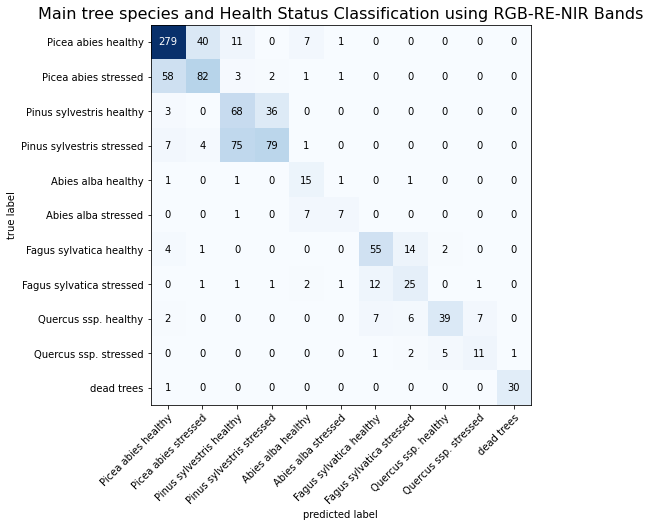

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
# Calculate the evaluation metrics for the ensemble model

report = classification_report(all_true_labels, ensemble_labels)
print(report)
#print(confusion_matrix(all_true_labels, ensemble_labels))

# Save the report to a file
with open(r'C:\Users\lwfeckesim\01_PyTorch\wze-uav\wze-uav-master\plots\report_RGB-RE-NIR_combined_11classes_plotsplit.txt', 'w') as f:
    f.write(report)

labels = np.array([0,1,2,3,4,5,6,7,8,9,10])
confmat = confusion_matrix(all_true_labels, ensemble_labels, labels=labels)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat, # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

# add title to confusion matrix plot
plt.title("Main tree species and Health Status Classification using RGB-RE-NIR Bands", fontsize=16)

fig.savefig(r'C:\Users\lwfeckesim\01_PyTorch\wze-uav\wze-uav-master\plots\confmat_RGB-RE-NIR_combined_11classes_plotsplit.png', dpi=300, bbox_inches='tight')

# Create a DataFrame from the confusion matrix
df_cm = pd.DataFrame(confmat)

# Export the confusion matrix to a CSV file
df_cm.to_csv(r'C:\Users\lwfeckesim\01_PyTorch\wze-uav\wze-uav-master\plots\confmat_RGB-RE-NIR_combined_11classes_plotsplit.csv', index=False)

In [23]:
# 2. Setup confusion matrix instance and compare predictions to targets
#from wze_uav.analysis import *
y_pred_tensor, y_labels_tensor, test_loss, test_recall, test_precision, test_f1_score, test_acc, y_logit, y_pred, y, y_preds = make_predictions(model=best_model,
                                 test_dataloader=test_dataloader, 
                                 device=device)

y_labels_tensor = y_labels_tensor.detach().cpu().numpy()
y_pred_tensor = y_pred_tensor.detach().cpu().numpy()

#confmat = ConfusionMatrix(num_classes=num_classes, task='multiclass')
#confmat_tensor = confmat(preds=y_pred_tensor,
#                         target=test_labels)
labels = np.array([0,1,2])
confmat = confusion_matrix(y_labels_tensor, y_pred_tensor, labels=labels)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat, # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

print(f"Test loss: {test_loss}")
print(f"Test precision: {test_precision}")
print(f"Test recall: {test_recall}")
print(f"Test F1score: {test_f1_score}")
#print(f"Test Kappa: {test_kappa}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Logits: {y_logit}")
print(f"Test Predictions: {y_pred}")
print(f"Test Labels: {y}")

NameError: name 'best_model' is not defined

In [ ]:
len(y_preds)

In [ ]:
y_set.cpu()

In [ ]:
test_dataset.labels

In [ ]:
y_preds = []
y_labels = []
labels = np.array([0,1,2])
test_loss, test_precision, test_recall, test_f1_score, test_acc = 0, 0, 0, 0, 0
count = 0
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
        y_labels.append(y.cpu())
        
        #other metrics
        test_acc += ((y_pred == y).sum().item()/len(y_pred))
        y_pred_class = y_pred.detach().cpu().numpy() 
        y_class = y.detach().cpu().numpy()
        test_precision += precision_score(y_class, y_pred_class, average='macro', zero_division=1, labels=labels)
        test_recall += recall_score(y_class, y_pred_class, average='macro', zero_division=1, labels=labels)
        #test_f1_score += f1_score(y_class, y_pred_class, average='macro', zero_division=1, labels=labels)
        
        #if count >= 1:
        #    y_set = torch.cat((y_set, y))
        #    count = count + 1
        #else:
        #    y_set = y
        #    count = count + 1
        
test_loss = test_loss / len(test_dataloader)
test_precision = test_precision / len(test_dataloader)
test_recall = test_recall / len(test_dataloader)
#test_f1_score = test_f1_score / len(test_dataloader)
#test_kappa = test_kappa / len(dataloader)
test_acc = test_acc / len(test_dataloader)
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
test_f1_score = f1_score(y_set.detach().cpu().numpy(), y_pred_tensor.cpu().numpy(), average='macro', zero_division=0, labels=[0,1,2])

# Print classification report
y_true = y_set.detach().cpu().numpy()
report = classification_report(y_true, y_pred_tensor.cpu().numpy(), target_names=class_names)
print(report)

In [ ]:
test_f1_score

In [ ]:
make = (y_class == y_pred_class)
make

In [ ]:
torch.softmax(y_logit, dim=1).argmax(dim=1)

In [ ]:
y

In [ ]:
test = (y_pred == y).sum().item()/16

In [ ]:
test

In [ ]:
 y_pred_class = y_pred.detach().cpu().numpy() 

In [ ]:
y_pred_class